In [126]:
import numpy as np
import torch
#from scipy import io
#from scipy import stats
import pickle

from api_neurotask import *
#from preprocessing_funcs import *

import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import adjust_spines

### Load dataset

Datasets are stored as .parquet (columnar) files and the name reveals data_set_id, bin_size and data_set_name respectively.

In [10]:
parquet_file_path = 'data/4_1_MaXuan_CO.parquet'
df, bin = load_and_filter_parquet(parquet_file_path, ['A', 'I','F'])

Data loaded from data/4_1_MaXuan_CO.parquet with bin size of 1 ms
Events columns: ['EventGo_cue', 'EventTarget_Onset']
Covariates columns: ['force_x', 'force_y', 'target_dir', 'cursor_pos_x', 'cursor_pos_y', 'cursor_vel_x', 'cursor_vel_y', 'cursor_acc_x', 'cursor_acc_y', 'target_ID']


In [11]:
bin # ms

1.0

In [24]:
df[(df['animal']==df['animal'].unique()[0])&(df['session']==df['session'].unique()[0])]

,Neuron1,Neuron2,Neuron3,Neuron4,Neuron5,Neuron6,Neuron7,Neuron8,Neuron9,Neuron10,...,cursor_pos_x,cursor_pos_y,cursor_vel_x,cursor_vel_y,cursor_acc_x,cursor_acc_y,target_ID,datasetID,EventGo_cue,EventTarget_Onset
6638102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.759504,-0.675056,0.487150,0.138853,2.127123,0.398631,7.0,4,False,False
6638103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.759992,-0.674917,0.489251,0.139238,2.074719,0.372236,7.0,4,False,False
6638104,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.760482,-0.674777,0.491300,0.139597,2.022440,0.346138,7.0,4,False,False
6638105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.760975,-0.674637,0.493296,0.139930,1.970333,0.320364,7.0,4,False,False
6638106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.761469,-0.674497,0.495240,0.140238,1.918452,0.294940,7.0,4,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7350876,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.796602,-0.882786,0.100641,0.070497,0.101366,2.532269,4.0,4,False,False
7350877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.796702,-0.882715,0.100734,0.073034,0.083374,2.542185,4.0,4,False,False
7350878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.796803,-0.882640,0.100808,0.075581,0.065299,2.550297,4.0,4,False,False
7350879,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.796904,-0.882563,0.100864,0.078135,0.047124,2.556706,4.0,4,False,False


In [27]:
df.groupby(['animal', 'session'])['trial_id'].nunique().reset_index(name='unique_trials_per_session')

,animal,session,unique_trials_per_session
0,2,1,191
1,2,2,207
2,2,3,209
3,2,4,205
4,2,5,210
5,2,6,171
6,2,7,199
7,2,8,239
8,2,9,239
9,2,10,208


In [12]:
neurons = [neuron for neuron in df.columns if neuron.startswith('Neuron')]

In [56]:
[col for col in df.columns if col.startswith('Event')]

['EventGo_cue', 'EventTarget_Onset']

### Preprocess for GPFA

For a session and animal of choice, convert dataframe to list of numpy array spike trains. You can also choose larger bin sizes with rebin().

In [18]:
from gpfa_utils import dataframe_to_spike_trains

In [29]:
session_id=9
animal_id=2

In [31]:
re_sample=10
df_gpfa = df[(df['animal']==animal_id)&(df['session']==session_id)]
df_gpfa = rebin(df_gpfa, prev_bin_size = bin, new_bin_size = 10)

In [36]:
dt=bin*re_sample # ms
dt

10.0

In [38]:
seqs = dataframe_to_spike_trains(df_gpfa, neurons)

In [40]:
seqs[0] # (bins, square root transform of dense array)

(398, array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 1.41421356, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 1.        ,
        0.        ]]))

In [42]:
seqs[0][1].shape # (neurons, bins)

(95, 398)

In [44]:
dt

10.0

### GPFA

In [47]:
latent_dimensionality=12
min_var_frac=0.01
min_var_frac_explanation="""fraction of overall data variance for each observed dimension to set as
        the private variance floor.  This is used to combat Heywood cases,
        where ML parameter learning returns one or more zero private variances.
        Default: 0.01
        (See Martin & McDonald, Psychometrika, Dec 1975.)"""

tau_init=100.0 # ms # GP timescale initialization in msec
eps_init=1.0e-3 # GP noise variance initialization
em_tol=1.0e-8 # stopping criterion for EM
em_max_iters=500 # max EM iterations
freq_ll=5 # every freq_ll steps in EM likelihood is computed
verbose=False # feedback or not

bin_width=dt # ms
#tau_init=tau_init.rescale("ms").magnitude

verbose = False # print fitting info

In [49]:
# Check if training data covariance is full rank
y_all = np.hstack(seqs["y"])
y_dim = y_all.shape[0]

if np.linalg.matrix_rank(np.cov(y_all)) < y_dim:
    errmesg = (
        "Observation covariance matrix is rank deficient.\n"
        "Possible causes: "
        "repeated units, not enough observations."
    )
    raise ValueError(errmesg)

In [51]:
if verbose:
    print("Number of training trials: {}".format(len(seqs)))
    print("Latent space dimensionality: {}".format(latent_dimensionality))
    print(
        "Observation dimensionality: {}".format(
            has_spikes_bool.sum()
        )
    )

### GPFA

We run gpfa, based on core implementation in [elephant](https://elephant.readthedocs.io/en/latest/reference/gpfa.html), but without using Neo spike train preprocessing.

In [58]:
from elephant.gpfa import gpfa_core, gpfa_util

In [60]:
# The following does the heavy lifting.
params_estimated, fit_info = gpfa_core.fit(
    seqs_train=seqs,
    x_dim=latent_dimensionality,
    bin_width=bin_width,
    min_var_frac=min_var_frac,
    em_max_iters=em_max_iters,
    em_tol=em_tol,
    tau_init=tau_init,
    eps_init=eps_init,
    freq_ll=freq_ll,
    verbose=verbose
)

Initializing parameters using factor analysis...

Fitting GPFA model...


And now transform:

Obtain trajectories of neural activity in a low-dimensional latent
variable space by inferring the posterior mean of the obtained GPFA
model and applying an orthonormalization on the latent variable space.

In [67]:
transform_info = dict()
returned_data=['latent_variable', 'VsmGP']

In [69]:
seqs, ll = gpfa_core.exact_inference_with_ll(
    seqs, params_estimated, get_ll=True
)

In [70]:
ll

7096781.785471878

seqs has been augmented with latents, Vsm, and VsmGP (GP posterior over time)

In [72]:
seqs.dtype.names

('T', 'y', 'latent_variable', 'Vsm', 'VsmGP')

e.g. last trial:

In [74]:
seqs[-1]['y'].shape

(95, 316)

In [75]:
seqs[-1]['latent_variable'].shape

(12, 316)

In [76]:
seqs[-1]['Vsm'].shape

(12, 12, 316)

In [77]:
seqs[-1]['VsmGP'].shape

(316, 316, 12)

In [78]:
transform_info["log_likelihood"] = ll
transform_info["num_bins"] = seqs["T"]

Orthonormalize latent space.

In [80]:
Corth, seqs = gpfa_core.orthonormalize(params_estimated, seqs)

In [81]:
transform_info["Corth"] = Corth
if len(returned_data) == 1:
    gpfa_val_result = seqs[returned_data[0]]
gpfa_val_result =  {x: seqs[x] for x in returned_data}

In [82]:
gpfa_val_result.keys()

dict_keys(['latent_variable', 'VsmGP'])

In [83]:
params_estimated.keys()

dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes', 'Corth'])

In [85]:
with open('save_pickles/MaXuan_example_data_set_animal_{}_session_{}_latent_dim_{}.pickle'.format(
    animal_id,session_id,latent_dimensionality), 'wb') as f:
    pickle.dump({
        'params':params_estimated,
        'latents':gpfa_val_result
    }, f)

In [86]:
length_scales = params_estimated['gamma']
params_estimated.keys()

dict_keys(['covType', 'gamma', 'eps', 'd', 'C', 'R', 'notes', 'Corth'])

In [87]:
length_scales

array([0.0037585 , 0.04864057, 0.0001781 , 0.00113893, 0.00080056,
       0.00157725, 0.00140569, 0.00183747, 0.01120921, 0.00593796,
       0.0094439 , 0.01858261])

In [91]:
GPFA_loadings=params_estimated['C']
GPFA_loadings.shape

(95, 12)

GPFA has estimated latent signals for the different trials with appropriate different amount of time points!

sanity checks:

In [95]:
gpfa_val_result['latent_variable'].shape

(239,)

In [96]:
df[(df['animal']==animal_id)&(df['session']==session_id)]['trial_id'].unique().shape

(239,)

3 different trials:

In [99]:
gpfa_val_result['latent_variable'][0].shape

(12, 398)

In [100]:
gpfa_val_result['latent_variable'][1].shape

(12, 433)

In [101]:
gpfa_val_result['latent_variable'][2].shape

(12, 411)

Plot latent signals for a specified trial_id

In [104]:
trial_id=7

In [108]:
print('For session {}, animal {} and trial {}:'.format(session_id, animal_id, trial_id))

For session 9, animal 2 and trial 7:


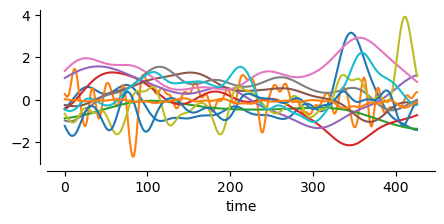

In [147]:
fig, ax = plt.subplots(1, 1, figsize =(5, 2))

for l in range(0,latent_dimensionality):
    plt.plot(
        range(0,gpfa_val_result['latent_variable'][np.where(df_gpfa['trial_id'].unique()==trial_id)[0][0]].shape[1]),
        gpfa_val_result['latent_variable'][np.where(df_gpfa['trial_id'].unique()==trial_id)[0][0]][l,:]
    )
ax.set_xlabel("time")
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

### Additional possible analyses:

#### Estimate readouts, decode trajectories from latents

In [115]:
from decode_utils import estimate_readout_matrix, expected_ll_poisson

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

Choose animal id, session id and latent dimensionality to load gpfa results

In [117]:
animal_id=2
session_id=9
latent_dimensionality=12

In [120]:
with open('save_pickles/MaXuan_example_data_set_animal_{}_session_{}_latent_dim_{}.pickle'.format(
    animal_id,session_id,latent_dimensionality), 'rb') as f:
    gpfa_results=pickle.load(f)

In [122]:
readout_iter=10
C_hat, loss_log = estimate_readout_matrix(
    df_gpfa,
    neurons,
    gpfa_results['latents']['latent_variable'],
    dt,
    readout_iter
    )

In [128]:
C_hat(torch.as_tensor(gpfa_val_result['latent_variable'][0],dtype=torch.float32).T).shape

torch.Size([398, 96])

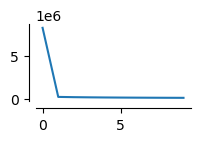

In [130]:
fig, ax = plt.subplots(1,1,figsize=(2,1))
ax.plot(loss_log)
sns.despine()
adjust_spines(ax,['bottom', 'left'])

In [132]:
ell_GPFA = expected_ll_poisson(
    df_gpfa,
    neurons,
    gpfa_results['latents']['latent_variable'],
    gpfa_results['latents']['VsmGP'],
    C_hat,
    dt)
ell_GPFA.item()

-71.74160766601562

**ToDo**: ????!!!!

Let us try to predict that behaviour from the latents.

In [135]:
cursor_position=[]
for n,trial_id in enumerate(df_gpfa['trial_id'].unique()):
    cursor_pos=np.concatenate(
        (df_gpfa[df_gpfa['trial_id']==trial_id]['cursor_pos_x'].values[:,np.newaxis],
         df_gpfa[df_gpfa['trial_id']==trial_id]['cursor_pos_y'].values[:,np.newaxis]
        ),
        axis=1
    )
    cursor_position.append(cursor_pos)

In [137]:
trial_id=7

In [138]:
latents=gpfa_results['latents']

In [139]:
z=latents['latent_variable'][np.where(df_gpfa['trial_id'].unique()==trial_id)[0][0]].T
b=cursor_position[np.where(df_gpfa['trial_id'].unique()==trial_id)[0][0]]

In [140]:
z.shape # time x latent dimensionality

(427, 12)

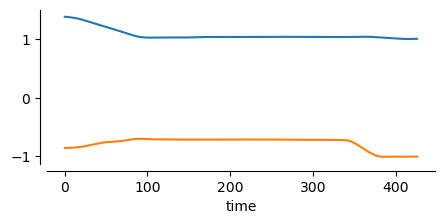

In [149]:
fig, ax = plt.subplots(1, 1, figsize =(5,2))

for b_dim in range(0,b.shape[1]):
    plt.plot(
        range(0,b.shape[0]),
        b[:,b_dim]
    )
ax.set_xlabel("time")
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

In [150]:
gscv_GPFA = GridSearchCV(Ridge(), {'alpha': np.logspace(-7, -1, 100)})

In [153]:
gscv_GPFA.fit(z, b)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-07, 1.14975700e-07, 1.32194115e-07, 1.51991108e-07,
       1.74752840e-07, 2.00923300e-07, 2.31012970e-07, 2.65608778e-07,
       3.05385551e-07, 3.51119173e-07, 4.03701726e-07, 4.64158883e-07,
       5.33669923e-07, 6.13590727e-07, 7.05480231e-07, 8.11130831e-07,
       9.32603347e-07, 1.07226722e-06, 1.23284674e-06, 1.41747...
       4.03701726e-03, 4.64158883e-03, 5.33669923e-03, 6.13590727e-03,
       7.05480231e-03, 8.11130831e-03, 9.32603347e-03, 1.07226722e-02,
       1.23284674e-02, 1.41747416e-02, 1.62975083e-02, 1.87381742e-02,
       2.15443469e-02, 2.47707636e-02, 2.84803587e-02, 3.27454916e-02,
       3.76493581e-02, 4.32876128e-02, 4.97702356e-02, 5.72236766e-02,
       6.57933225e-02, 7.56463328e-02, 8.69749003e-02, 1.00000000e-01])})

In [154]:
b_hat = gscv_GPFA.predict(z)

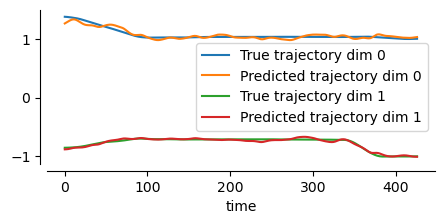

In [156]:
fig, ax = plt.subplots(1, 1, figsize =(5,2))

for b_dim in range(0,b.shape[1]):
    ax.plot(
        range(0,b.shape[0]),
        b[:,b_dim],
        label='True trajectory dim {}'.format(b_dim)
    )
    ax.plot(
        range(0,b.shape[0]),
        b_hat[:,b_dim],
        label='Predicted trajectory dim {}'.format(b_dim)
    )
ax.legend(loc='best')
ax.set_xlabel("time")
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

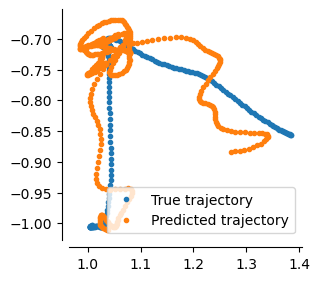

In [159]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(b[:,0],b[:,1], '.', label='True trajectory')
ax.plot(b_hat[:,0],b_hat[:,1], '.', label='Predicted trajectory')
ax.legend(loc='best')
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

R^2 score:

In [161]:
np.mean(1-np.sum((b-b_hat)**2, axis=1)/np.sum((b-b.mean(axis=0))**2,axis=1))

0.7728430340592006

Depending on the latent dimensionality you specify, the $R^2$ score can vary greatly. Perhaps just 4 latent dimensions, even though they capture most of the variance (>80%) is not enough to predict behaviour very well (negative $R^2$ scores). But e.g. 12 latent dimensions seems to do very well.
What about first predicting the firing rates before regressing onto behaviour though?

In [164]:
gscv_GPFA = GridSearchCV(Ridge(), {'alpha': np.logspace(-7, -1, 100)})

In [165]:
rates=dt*np.exp(C_hat(torch.as_tensor(z,dtype=torch.float32)).detach().numpy())

In [203]:
gscv_GPFA.fit(rates, b)

In [171]:
b_hat = gscv_GPFA.predict(rates)

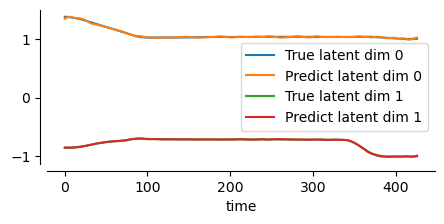

In [172]:
fig, ax = plt.subplots(1, 1, figsize =(5,2))

for b_dim in range(0,b.shape[1]):
    ax.plot(
        range(0,b.shape[0]),
        b[:,b_dim],
        label='True latent dim {}'.format(b_dim)
    )
    ax.plot(
        range(0,b.shape[0]),
        b_hat[:,b_dim],
        label='Predict latent dim {}'.format(b_dim)
    )
ax.legend(loc='best')
ax.set_xlabel("time")
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

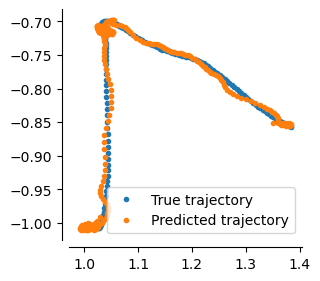

In [174]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(b[:,0],b[:,1], '.', label='True trajectory')
ax.plot(b_hat[:,0],b_hat[:,1], '.', label='Predicted trajectory')
ax.legend(loc='best')
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

In [178]:
np.mean(1-np.sum((b-b_hat)**2, axis=1)/np.sum((b-b.mean(axis=0))**2,axis=1))

0.9928275587954242

### Loading structure

In [183]:
params_estimated['gamma']

array([0.0037585 , 0.04864057, 0.0001781 , 0.00113893, 0.00080056,
       0.00157725, 0.00140569, 0.00183747, 0.01120921, 0.00593796,
       0.0094439 , 0.01858261])

Higher gamma --> faster timescale (smaller tau), you can check with plotting a certain dimension

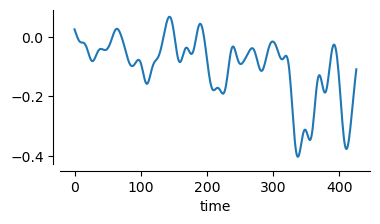

In [187]:
fig, ax = plt.subplots(1, 1, figsize =(4, 2))

for l in range(11,12):
    plt.plot(
        range(0,gpfa_val_result['latent_variable'][np.where(df_gpfa['trial_id'].unique()==trial_id)[0][0]].shape[1]),
        gpfa_val_result['latent_variable'][np.where(df_gpfa['trial_id'].unique()==trial_id)[0][0]][l,:]
    )
ax.set_xlabel("time")
sns.despine()
adjust_spines(ax, ['bottom', 'left'])

Possibly sort by time / 'length' scale:

In [190]:
length_scale_sort = np.argsort(params_estimated['gamma']) # high gamma to low
length_scale_sort

array([ 2,  4,  3,  6,  5,  7,  0,  9, 10,  8, 11,  1])

Choose:

In [225]:
#GPFA_loadings = params_estimated['Corth'] # normalized
GPFA_loadings = params_estimated['C'] # not normalized
#GPFA_loadings = params_estimated['C'][:,length_scale_sort] # not normalized, shuffled columns
#GPFA_loadings = C_hat.weight.detach().numpy()

In [227]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=17, n_init=1000).fit(GPFA_loadings)

In [228]:
clusters = kmeans.labels_

In [229]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
z=pca.fit_transform(GPFA_loadings)

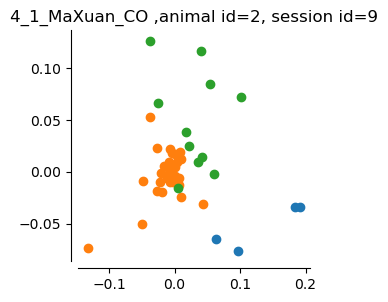

In [230]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
for c in np.unique(clusters):
    ax.scatter(z[clusters==c,0], z[clusters==c,1])
ax.set_title('{} ,animal id={}, session id={}'.format(parquet_file_path.split('/')[1].split('.')[0], animal_id, session_id))
sns.despine(ax=ax)
adjust_spines(ax, ['left', 'bottom'])

Often, one would find more structure in unnormalized loading matrix $C$. I do not know why yet.